<a href="https://colab.research.google.com/github/zrruziev/deep_learning_practice/blob/main/TENSORFLOW/TF_Input_Pipeline_benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarking `Tensorflow_Input_Pipeline` modules:

- `tf.keras.preprocessing.image.ImageDataGenerator`


- `tf.keras.preprocessing.image_dataset_from_directory`


- `tf.data.Dataset`

In [ ]:
import os
import time
from glob import glob
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2022-12-12 15:28:58.643683: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# ####### LIMIT GPU USAGE TO 1024MB #######

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#     try:
#         tf.config.set_logical_device_configuration(
#             gpus[0],
#             [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

In [ ]:
!python --version
print(f"Tensorflow {tf.__version__}")

Python 3.9.15
Tensorflow 2.9.0


### [Dataset Info](https://www.kaggle.com/datasets/wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment) | Download the dataset from [here...](https://www.kaggle.com/datasets/wadhasnalhamdan/date-fruit-image-dataset-in-controlled-environment/download?datasetVersionNumber=1)



### Define a dataset path

In [ ]:
dataset_path = 'date_fruit/'


BATCH_SIZE = 16
IMG_SIZE = 224

### Prepare `imgDataGen` object by utilizing `ImageDataGenerator` module

In [ ]:
imgDataGen = tf.keras.preprocessing.image.ImageDataGenerator()

imgDataGen = imgDataGen.flow_from_directory(dataset_path,
                                              target_size=(IMG_SIZE,IMG_SIZE),
                                              batch_size=BATCH_SIZE,
                                              class_mode="sparse",
                                              color_mode="rgb",
                                              shuffle=True,
                                              interpolation='nearest')

Found 1658 images belonging to 9 classes.


['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


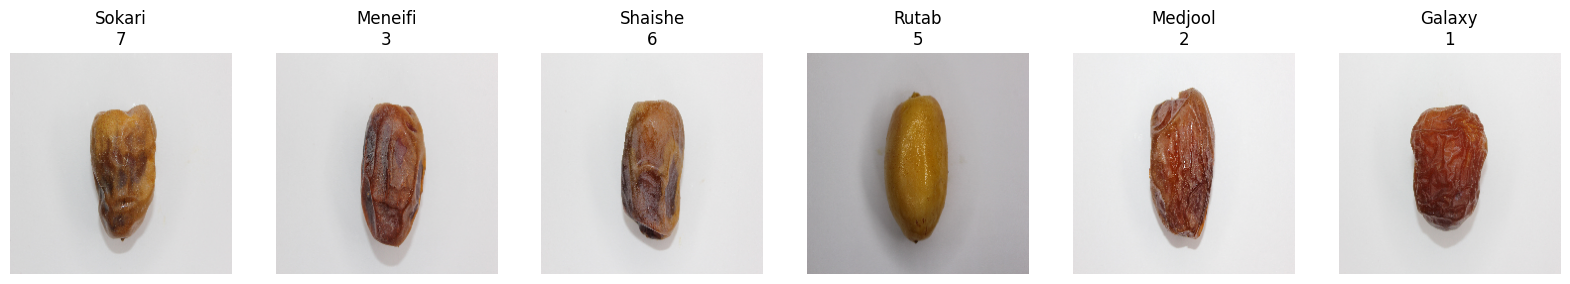

In [ ]:
# Show classes
imgDataGen_classes = list(imgDataGen.class_indices.keys())
print(imgDataGen_classes)

for images, labels in imgDataGen:
    plt.figure(figsize=(20, 5))
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        plt.imshow(images[i].astype('uint8'))
        label = int(labels[i])
        plt.title(f"{imgDataGen_classes[label]}\n{label}")
        plt.axis("off")
    break

***

### Prepare `imgDataFromDir` object by utilizing `image_dataset_from_directory` module

In [ ]:
imgDataFromDir = tf.keras.preprocessing.image_dataset_from_directory(dataset_path,
                                                                      labels="inferred",
                                                                      label_mode="int",
                                                                      color_mode="rgb",
                                                                      batch_size=BATCH_SIZE,
                                                                      image_size=(IMG_SIZE, IMG_SIZE),
                                                                      interpolation='nearest',
                                                                      shuffle=True)

class_names = imgDataFromDir.class_names

imgDataFromDir = imgDataFromDir.cache()
imgDataFromDir = imgDataFromDir.prefetch(tf.data.AUTOTUNE)
type(imgDataFromDir)

Found 1658 files belonging to 9 classes.


2022-12-12 15:29:00.886888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 15:29:01.198986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10296 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


tensorflow.python.data.ops.dataset_ops.PrefetchDataset

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


2022-12-12 15:29:02.062976: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


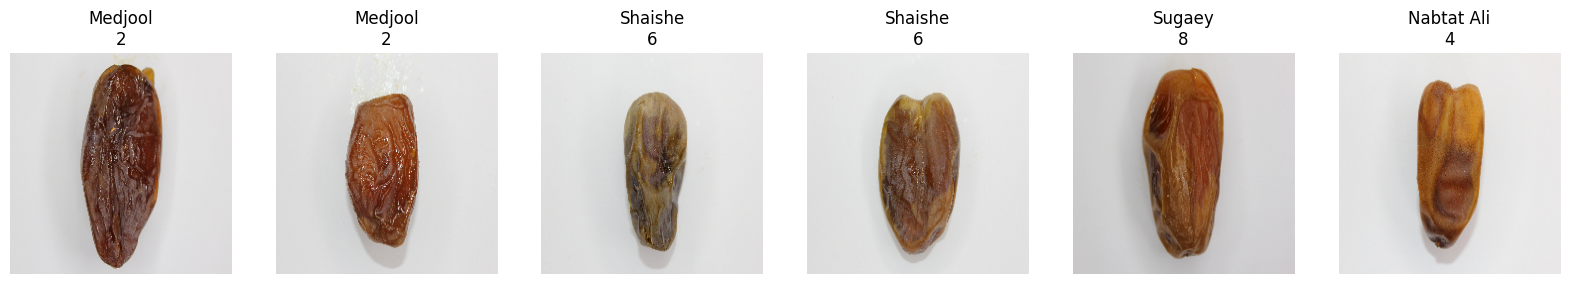

In [ ]:
print(class_names)

# Show some data-samples with their classnames and corresponding one-hot encoded labels
for images, labels in imgDataFromDir:
    plt.figure(figsize=(20, 5))
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        label = int(labels[i])
        plt.title(f"{class_names[label]}\n{label}")
        plt.imshow(images[i].numpy().astype('uint8'))
#         plt.title(f"{class_names[np.argmax(labels[i].numpy())]}\n{labels[i]}")
        plt.axis("off")
    break

***

### Prepare `tf_data` object by utilizing `tf.data.Dataset` api

In [ ]:
subdirs = []
for subdir in sorted(tf.io.gfile.listdir(dataset_path)):
    if tf.io.gfile.isdir(tf.io.gfile.join(dataset_path, subdir)):
        if subdir.endswith("/"):
            subdir = subdir[:-1]
        subdirs.append(subdir)

class_names = subdirs
tf_data_classes = np.array(class_names)


def parse_image_and_label(filename):
    parts = tf.strings.split(filename, os.sep)
    boolean_label = parts[-2] == class_names
    label = tf.argmax(boolean_label)  # for SparseCategoricalCrossentropy()
#     label = tf.one_hot(label, len(class_names))  # for CategoricalCrossentropy()

    image = tf.io.read_file(filename)
    image = tf.io.decode_image(image, channels=3)
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    # image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    return image, label


tf_data = tf.data.Dataset.list_files(f"{dataset_path}*/*/")
tf_data = tf_data.map(parse_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
tf_data = tf_data.shuffle(BATCH_SIZE*8)
tf_data = tf_data.cache()
tf_data = tf_data.batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
tf_data = tf_data.prefetch(tf.data.AUTOTUNE)

<details>
  <summary><font size="4" color="darkgreen"><b>Click to see another way for tf.data.Dataset preparation</b></font></summary>

- Here `tf.data.Dataset.from_tensor_slices` is used instead of `tf.data.Dataset.list_files`    
    
```python
def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

def configure_for_performance(ds):
    ds = ds.shuffle(1024)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


class_names = sorted(os.listdir(dataset_path))
filenames = glob(dataset_path + '/*/*')
random.shuffle(filenames)
labels = [class_names.index(name.split('/')[-2]) for name in filenames]
# print(class_names)
# for img, label in zip(filenames, labels):
#     print(label, img)


filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
tf_data = configure_for_performance(ds)
```
    
    

</details>

    


['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'Nabtat Ali', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


2022-12-12 15:29:03.740342: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


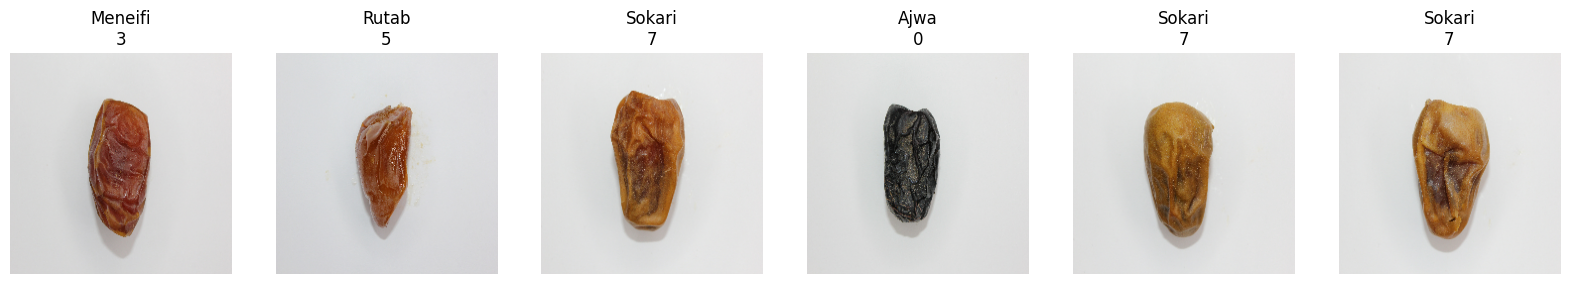

In [ ]:
print(class_names)
# Show some data-samples with their classnames and corresponding one-hot encoded labels
for images, labels in tf_data:
    plt.figure(figsize=(20, 5))
    for i in range(6):
        ax = plt.subplot(1, 6, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
#         plt.title(f"{tf_data_classes[tf.argmax(labels[i])]}\n{labels[i].numpy()}")
        plt.title(f"{class_names[labels[i]]}\n{labels[i].numpy()}")
        plt.axis("off")
    break

***

## Build a model

In [ ]:
def build_model():
    
    model = tf.keras.Sequential([

                tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
                tf.keras.layers.MaxPooling2D(2,2),

                tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                tf.keras.layers.MaxPooling2D(2,2),        

                tf.keras.layers.GlobalAvgPool2D(),

                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(len(class_names), activation='softmax')
                ])


    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 128)              0         
 lobalAveragePooling2D)                                          
                                                        

### Prepare training function

In [ ]:
def train_the_model(data_gen, epochs=5, profiler=False):
    
    tf.keras.backend.clear_session()
    
    model = build_model()

    if profiler:
        # Prepare tensorboard with profiler
        tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f'tboard/{profiler}',
                                                     histogram_freq=1,
                                                     profile_batch = (280,300)) # between 280:300 batches
        
        # Start training
        model.fit(data_gen, epochs=epochs, callbacks=[tensorboard])
    else:
        # Start training
        model.fit(data_gen, epochs=epochs)

### Training with `imgDataGen`

In [ ]:
train_the_model(imgDataGen)
# train_the_model(imgDataGen, profiler='ImageDataGenerator')

Epoch 1/5


2022-12-12 15:29:06.234869: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


104/104 [==============================] - 54s 508ms/step - loss: 5.7711 - accuracy: 0.2394
Epoch 2/5
104/104 [==============================] - 53s 504ms/step - loss: 1.3337 - accuracy: 0.4982
Epoch 3/5
104/104 [==============================] - 53s 509ms/step - loss: 1.0272 - accuracy: 0.6152
Epoch 4/5
104/104 [==============================] - 55s 525ms/step - loss: 0.8612 - accuracy: 0.6761
Epoch 5/5
104/104 [==============================] - 53s 504ms/step - loss: 0.8320 - accuracy: 0.6743


### Training with `imgDataFromDir`

In [ ]:
train_the_model(imgDataFromDir)
# train_the_model(imgDataFromDir, profiler='imgDataFromDir')

Epoch 1/5
104/104 [==============================] - 8s 67ms/step - loss: 3.3941 - accuracy: 0.3076
Epoch 2/5
104/104 [==============================] - 3s 32ms/step - loss: 1.1550 - accuracy: 0.5778
Epoch 3/5
104/104 [==============================] - 3s 31ms/step - loss: 0.9262 - accuracy: 0.6592
Epoch 4/5
104/104 [==============================] - 3s 31ms/step - loss: 0.7608 - accuracy: 0.7177
Epoch 5/5
104/104 [==============================] - 3s 31ms/step - loss: 0.6939 - accuracy: 0.7443


### Train with `tf_data`

In [ ]:
train_the_model(tf_data)
# train_the_model(tf_data, profiler='tf_data')

Epoch 1/5
104/104 [==============================] - 8s 69ms/step - loss: 5.6446 - accuracy: 0.1448
Epoch 2/5
104/104 [==============================] - 3s 33ms/step - loss: 1.7970 - accuracy: 0.3396
Epoch 3/5
104/104 [==============================] - 3s 33ms/step - loss: 1.3178 - accuracy: 0.4964
Epoch 4/5
104/104 [==============================] - 3s 33ms/step - loss: 1.1935 - accuracy: 0.5398
Epoch 5/5
104/104 [==============================] - 3s 33ms/step - loss: 0.9611 - accuracy: 0.6423


***

### Show Tensorboard if you trained the model with `profiler`

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir tboard/

***

## The above results may differ by hardware specs:

**Experiment hardware specs:**
- CPU: i5-11600K, 3.90GHz, 6cores(12threads)
- GPU: NVIDIA GeForce RTX 2060 12GB
- OS : Ubuntu 22.04.1 LTS(64-bit)

***